In [89]:
import data_process
reload(data_process)
import research
reload(research)
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [2]:
target = 'ru0'
train_start, train_end, test_start, test_end = '20180326', ' 20180329', '20180330', '20180330'
period = '1s'
if period == '0s':
    lag = '500ms'
else:
    lag = period
resample = False
resample_period = '2s'

In [13]:
rese = research.Research(target=target)
train = research.Train(target = target)

In [4]:
tickerlst = rese.get_symbols()
print tickerlst

['rb0', 'hc0', 'ni0', 'zn0', 'cu0', 'j10', 'i10', 'jm0', 'MA0', 'pb0']


get most correlated symbols from mysql database according to appointed period and lag.

In [5]:
train_daylst = rese.generate_daylst(train_start, train_end)
test_daylst = rese.generate_daylst(test_start, test_end)

In [14]:
train_data = rese.load_data(tickerlst, daylst=train_daylst, lag=lag, period = period)
test_data = rese.load_data(tickerlst, daylst=test_daylst, lag=lag, period = period)

In [ ]:
train_

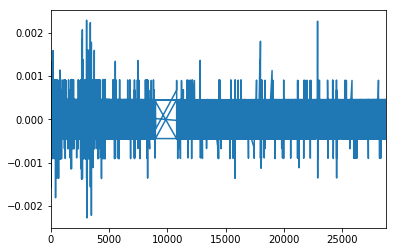

In [16]:
none_zero_flag = [True if val != 0 else False for val in train_data[target].values]
none_zero = train_data[none_zero_flag]
none_zero[target].plot()
plt.show()

std of train data is 0.000144


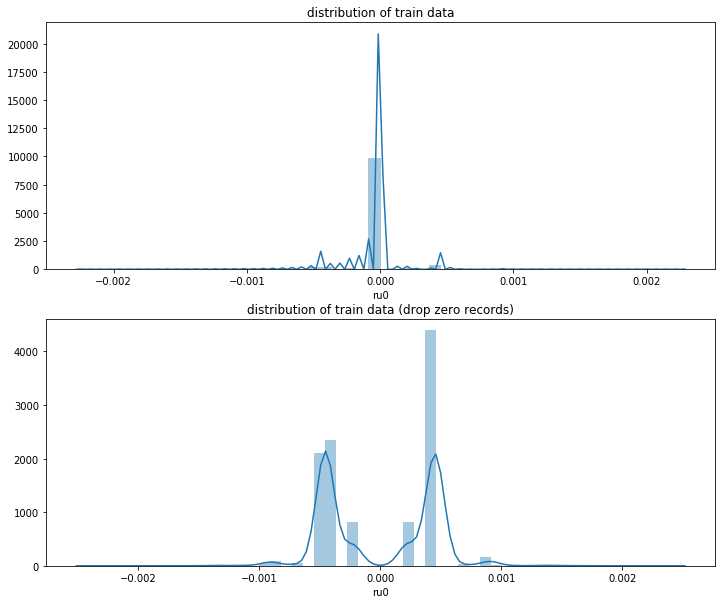

std of none-zero df is 0.000463


In [17]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target])
print 'std of train data is %f' %np.std(train_data[target].values)

plt.subplot(2,1,2)
sns.distplot(none_zero[target])
plt.title('distribution of train data (drop zero records)')
plt.show()
none_zero_std = np.std(none_zero[target])
print 'std of none-zero df is %f' %none_zero_std

           std of train data is 0.000144, mean of train data is 0.000000


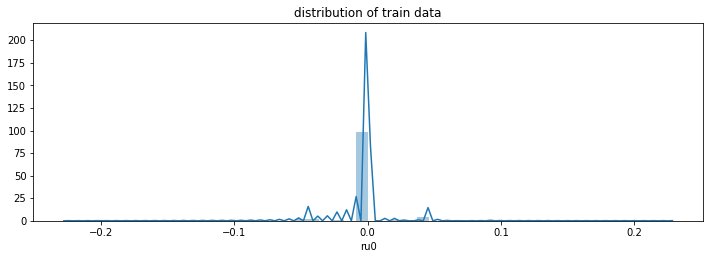

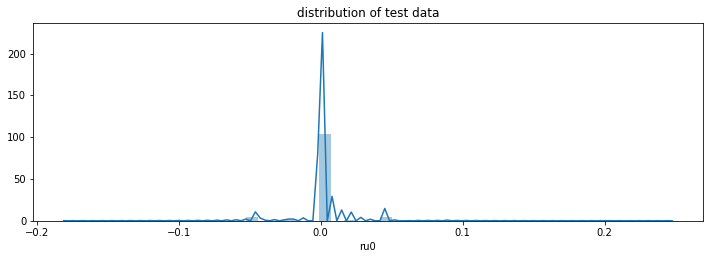

           std of test data is 0.000145, mean of train data is 0.000001


In [18]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of train data')
sns.distplot(train_data[target]*100)
print '           std of train data is %f, mean of train data is %f' %(np.std(train_data[target].values), np.mean(train_data[target].values))

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.title('distribution of test data')
sns.distplot(test_data[target]*100)
plt.show()
print '           std of test data is %f, mean of train data is %f' %(np.std(test_data[target].values),np.mean(test_data[target].values))

In [19]:
train_price = rese.load_price(train_daylst,lag)
test_price = rese.load_price(test_daylst, lag)

In [20]:
if resample:
    train_data = train.sample(resample_period=resample_period, df=train_data, keep_target_no_zero=False)
    test_data = train.sample(resample_period = resample_period, df=test_data, keep_target_no_zero=False)

本来是准备把大于3倍方差的去掉的，但是发现去了之后剩下的0值更多了
所以考虑以下做法：
    1.由于0值太多，所以分成多个数据集，每个数据集由数量相近的0值记录和非零值记录组成
    2.对于每个数据集，再查看大于3倍方差的，看有没有必要去掉

In [21]:
def easy_ensemble(data, clf, target=target,n_model='default', zero_no_zero_times = 2, cut_outlier=True, thres=3):
    if n_model == 'default':
        count = 0  # 0记录的数量
        for val in data[target].values:
            if val == 0:
                count += 1
        l = data.shape[0]
        n_model = count / (l - count) / zero_no_zero_times  # 使得划分的模型数和0值、非0值比值是指定的比值，这样就能保证每个clf的数据里非0和0值差不多
    target_col = data[target].values
    zero_flag = [True if val == 0 else False for val in target_col]
    not_zero_flag = [True if val != 0 else False for val in target_col]
    zero_records = data[zero_flag]
    not_zero_records = data[not_zero_flag]
    if cut_outlier:  # 去掉非零值中的outliers
        mean = np.mean(not_zero_records.values)
        std = np.std(not_zero_records.values)
        flag=[]
        for val in not_zero_records[target].values:
            flag1, flag2 = False, False
            to_test_1, to_test_2 = mean+thres*std,mean-thres*std
            if val < to_test_1:
                flag1 = True
            if val > to_test_2:
                flag2 = True
            if flag1 and flag2:
                flag.append(True)
            else:
                flag.append(False)
        not_zero_records = not_zero_records[flag]
    zero_dic = df_split(zero_records, n=n_model)
    clf_dic, train_score = {}, {}
    for key in zero_dic.keys():
        this_df = pd.concat([not_zero_records, zero_dic[key]])
        this_df = shuffle(this_df)
        this_x, this_y = train.split_x_y(this_df)
        clf.fit(this_x, this_y)
        train_score[key] = clf.score(this_x, this_y)
        clf_dic[key] = clf
    return clf_dic, train_score
        
def df_split(data, n):
    '''split dataframe into n parts'''
    data = shuffle(data)
    l = data.shape[0]
    len_per_part = l/n
    dic = {}
    num=1
    start=0
    while num< n:
        end = start+len_per_part
        temp = data.iloc[start:end,:]
        dic[str(num)] = temp
        start=end
        num+=1
    dic[str(n)] = data.iloc[start:,:]
    return dic

def cut_outlier(data, target_col=target, thres=3):   # 去掉数值大于thres倍方差的
    df = data.copy()
    scaled = StandardScaler().fit_transform(df[target_col][:,np.newaxis])
    flag = [True if abs(val) <= thres else False for val in scaled]
    return data[flag]

In [22]:
from sklearn.linear_model import Ridge, RidgeCV
clf = RidgeCV(alphas=np.arange(0.01,1,0.01),normalize=True)
clf_dic , score_dic = easy_ensemble(train_data, clf)

In [23]:
def easy_ensemble_predict(x, clf_dic, score_dic):
    score_sum = sum(score_dic.values())
    weight = {}
    res = [0 for i in range(x.shape[0])]
    for key in score_dic.keys():
        weight[key] = score_dic[key]/ score_sum
        this_clf = clf_dic[key]
        this_pred = this_clf.predict(x)
        res += weight[key] * this_pred
    return res

def asset_plot(asset_record):
    max_list, min_list = [], []
    values = asset_record.values()
    for i in range(len(asset_record)):
        max_list.append(values[i][0])
        min_list.append(values[i][1])
    plt.plot(max_list, label='max')
    plt.plot(min_list, label='min')
    plt.legend()
    plt.show()

def get_best_thres(dic, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(profit)):
        this_profit = profit[i][0] + profit[i][1]
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print profit[i][0], profit[i][1]
    return dic.keys()[best_thres]

def get_best_thres_by_tr_test(train_dic, test_dic, train_weig, test_weig, max_weight = 1, min_weight = 1): # 从asset记录中获取最好的一条记录
    train_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], train_dic.values())
    test_profit = map(lambda set_x : [int(set_x[0])-5000000,int(set_x[-1])-5000000], test_dic.values())
    max_profit = -1000000
    best_thres = 0
    for i in range(len(train_profit)):
        this_profit = (train_profit[i][0] + train_profit[i][1])*train_weig+(test_profit[i][0] + test_profit[i][1])*test_weig
        if this_profit > max_profit:
            max_profit = this_profit
            best_thres = i
            print test_profit[i][0], test_profit[i][1]
    return train_dic.keys()[best_thres]

In [24]:
train_x, train_y= train.split_x_y(train_data)
train_predict = easy_ensemble_predict(train_x, clf_dic, score_dic)

In [25]:
score_dic

{'1': 0.046281212555671636,
 '2': 0.046097882654332456,
 '3': 0.046780044546452904,
 '4': 0.047277293121912534}

In [26]:
contrast = pd.DataFrame({'pred':train_predict, 'true':train_y})
print 'corr between train_predict and train_y'
contrast.corr()

corr between train_predict and train_y


,pred,true
pred,1.000000,0.135163
true,0.135163,1.000000


In [27]:
clf_1 = RidgeCV(alphas=np.arange(0.01,1,0.01),normalize=True)
clf_1.fit(train_x, train_y)
clf_1.score(train_x, train_y)

0.01841438425390074

In [28]:
test_x, test_y = train.split_x_y(test_data)
test_pred = easy_ensemble_predict(test_x, clf_dic, score_dic)
test_contrast = pd.DataFrame({'pred':test_pred, 'true':test_y})
print 'corr between test_predict and test_y'
test_contrast.corr()

corr between test_predict and test_y


,pred,true
pred,1.000000,0.085658
true,0.085658,1.000000


预处理，查看有没有outlier

In [29]:
trade = research.Trade(target)

In [30]:
model_name = 'ridge_ensemble'
date = str(pd.datetime.now()).split(' ')[0]
to_save_dir = '/home/hui/Documents/output/trade_asset/'+model_name+'/'+date+'/train/ask_bid/'
if not os.path.exists(to_save_dir):
    os.makedirs(to_save_dir)
record = {}

In [31]:
for buy_thres in np.arange(1,4,0.1):
    for sell_thres in np.arange(-1,-4,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        record[pair] = (max(asset), min(asset))
#         plt.figure(figsize= (12,8))
#         plt.plot(asset)
#         plt.title(str(buy_thres)+' : '+str(sell_thres))
#         plt.savefig(to_save_dir+pair+'.jpg')
#         plt.close()

research.py:154: Warning: Table 'future_fee' already exists
  primary key(ticker, fee_type))""")


In [32]:
test_record = {}
for buy_thres in np.arange(1,4,0.1):
    for sell_thres in np.arange(-1,-4,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(test_price, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
        test_record[pair] = (max(asset), min(asset))

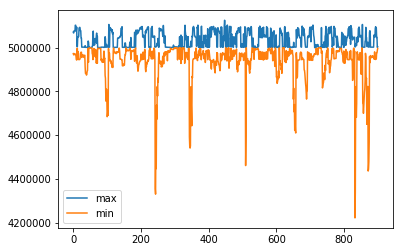

In [33]:
asset_plot(record)

In [24]:
thres = get_best_thres(record).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])

76455 -28196
82405 -28196
83955 -29644
110406 -28944
112478 -30933
109077 -25035


In [34]:
thres = get_best_thres_by_tr_test(record, test_record, 0.4,0.6).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print buy_thres, sell_thres

-150 -1501
-150 -1501
-150 -1501
83598 -6700
100049 -15149
93549 -5350
80498 -6700
124295 -12350
76797 -5400
118496 -9500
2.1 -2.4


In [47]:
thres = get_best_thres(record).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print buy_thres, sell_thres

76455 -28196
82405 -28196
83955 -29644
110406 -28944
112478 -30933
109077 -25035
2.3 -2.4


In [36]:
# buy_thres, sell_thres=2.2,-2.4
def test_model(daylst, clf_dic=clf_dic, score_dic=score_dic, load_instance=rese, train_instance=train, trade_instance=trade, 
    tickerlst=tickerlst, target=target, lag=lag, period=period, buy_thres=buy_thres, sell_thres=sell_thres,hold_per_trade=50):
    tmp_data = load_instance.load_data(tickerlst, daylst, lag, period)
    tmp_price = load_instance.load_price(daylst, lag)
    tmp_x, tmp_y = train_instance.split_x_y(tmp_data)
    tmp_predict = easy_ensemble_predict(tmp_x, clf_dic, score_dic)
    corr = np.corrcoef(tmp_predict, tmp_y)[0][-1]
    print 'corr value between predict value and true value is: %f' %corr
    tmp_asset = trade_instance.simu_trade1(tmp_price, tmp_predict,buy_thres, sell_thres,
        hold_per_trade=hold_per_trade)
    plt.figure(figsize= (10,6))
    plt.title('asset track of test data')
    plt.plot(tmp_asset)
    plt.show()

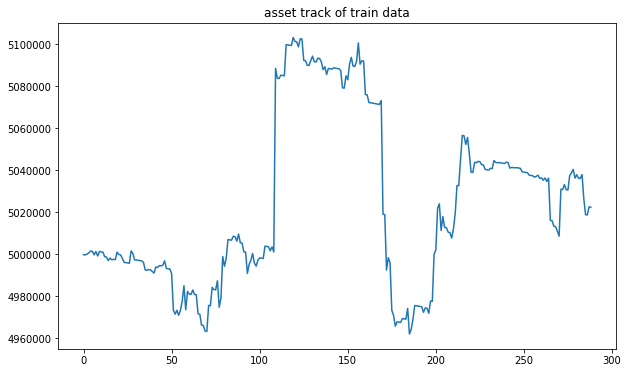

In [37]:
asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of train data')
plt.plot(asset)
plt.show()

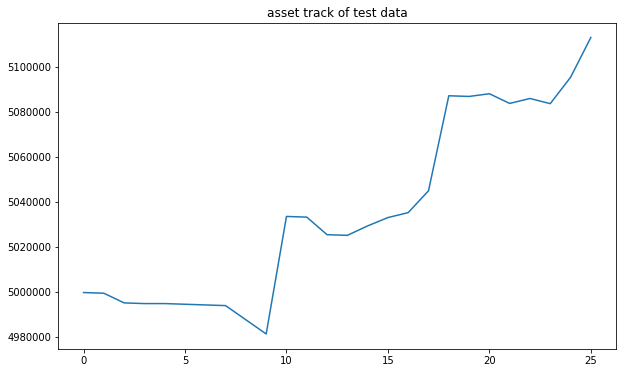

In [38]:
test_price_df = rese.load_price(test_daylst,period)
test_asset = trade.simu_trade1(test_price_df, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=100)
plt.figure(figsize= (10,6))
plt.plot(test_asset)
plt.title('asset track of test data')
plt.show()

----------------------------Simulate Trade-----------------------

corr value between predict value and true value is: 0.078850


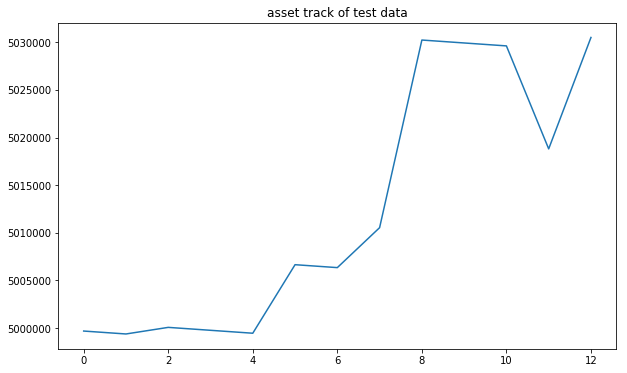

In [39]:
valid_daylst=rese.generate_daylst('20180315', '20180315')
test_model(valid_daylst,hold_per_trade=100)

corr value between predict value and true value is: 0.093063


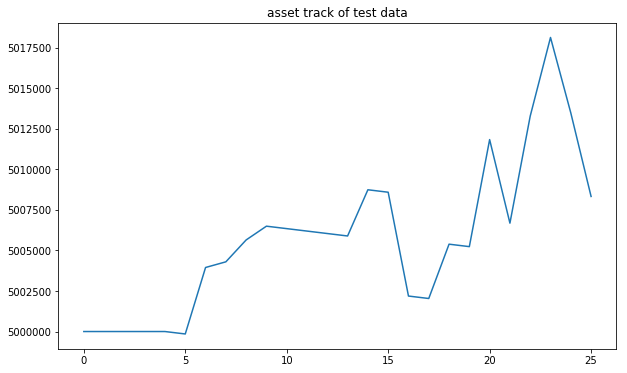

In [40]:
valid_daylst=rese.generate_daylst('20180410', '20180410')
test_model(valid_daylst,hold_per_trade=50)

corr value between predict value and true value is: 0.086316


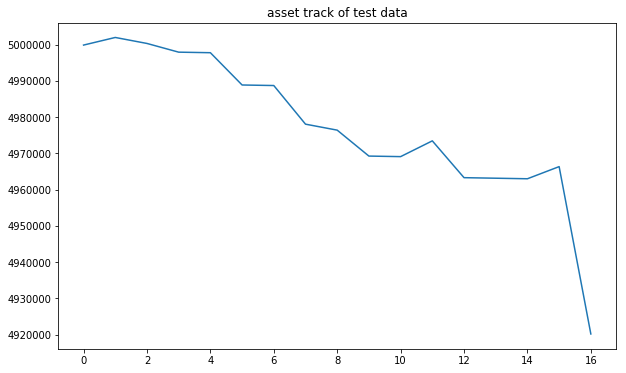

In [41]:
valid_daylst=rese.generate_daylst('20180411', '20180411')
test_model(valid_daylst,hold_per_trade=50)

corr value between predict value and true value is: 0.107064


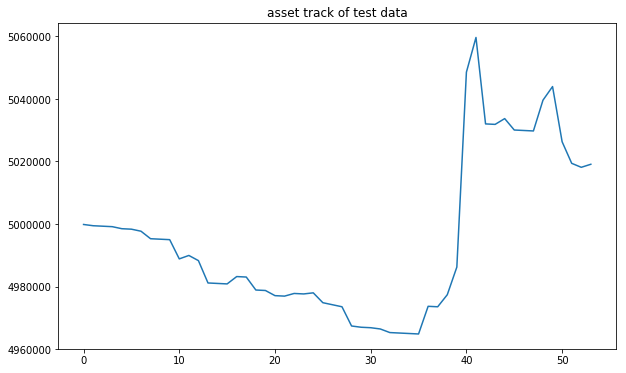

In [42]:
valid_daylst=rese.generate_daylst('20180412', '20180412')
test_model(valid_daylst,hold_per_trade=50)

In [ ]:
thres = get_best_thres_by_tr_test(record, test_record, train_weig=0.4, test_weig=0.6).split('_')
buy_thres, sell_thres = float(thres[0]), float(thres[1])
print 'buy_thres: %f, sell_thres: %f' %(buy_thres, sell_thres)

In [ ]:
asset = trade.simu_trade1(train_price, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.title('asset track of train data')
plt.plot(asset)
plt.show()

In [ ]:
test_price_df = rese.load_price(test_daylst,period)
test_asset = trade.simu_trade1(test_price_df, test_pred, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=50)
plt.figure(figsize= (10,6))
plt.plot(test_asset)
plt.title('asset track of test data')
plt.show()

In [ ]:
model_name = 'ridge'
to_save_dir = '/media/charles/charles_13162398828/hdd/output/trade_asset/'+model_name+'/cut_outliered/'
if not os.path.exists(to_save_dir):
    os.makedirs(to_save_dir)
record = {}
for buy_thres in np.arange(1,3,0.1):
    for sell_thres in np.arange(-1,-2,-0.1):
        pair = str(buy_thres)+'_'+str(sell_thres)
        asset = trade.simu_trade1(price_df, train_predict, buy_threshold=buy_thres,sell_threshold=sell_thres
                                  , hold_per_trade=5)
        record[pair] = (max(asset), min(asset))
        plt.figure(figsize= (12,8))
        plt.plot(asset)
        plt.savefig(to_save_dir+pair+'.jpg')
        plt.close()

In [73]:
from sklearn import ensemble

In [83]:
clf_1 = ensemble.GradientBoostingRegressor(n_estimators=100,max_depth=50)
clf_1.fit(train_x, train_y)
clf_1.score(train_x, train_y)

0.0

,rb0,hc0,ni0,zn0,cu0,j10,i10,jm0,MA0,pb0,ru0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000227
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.001180,-0.000281,-0.000153,0.000405,-0.000501,0.000000,0.000000,0.000000,0.000725,-0.000271,-0.001587
3,0.002508,0.000843,0.000306,0.000304,-0.000702,0.000938,-0.003415,0.000000,0.000725,-0.000271,-0.001360
4,0.001032,0.001547,0.000612,0.000101,-0.000201,0.000670,-0.002277,-0.001000,0.000362,0.000000,0.000000
5,0.000147,0.000843,0.000102,0.000000,0.000000,0.000268,0.002284,-0.001000,0.000362,0.000271,0.000454
6,0.000736,0.000842,0.000153,-0.000405,0.000401,0.001205,0.001141,0.000000,0.000362,0.000136,0.000908
7,0.001324,0.000702,0.000357,-0.000202,0.000602,0.000535,0.001140,0.000400,0.000362,0.000000,-0.000454
8,0.000736,0.000561,0.000356,0.000202,0.000201,0.000000,0.001140,0.000400,-0.000723,0.000136,-0.001361
9,0.001176,0.000841,0.000407,0.000304,-0.000201,0.000401,0.000569,0.000000,-0.000723,0.000000,-0.000681


In [90]:
pre = data_process.pre_process('/hdd/ctp/day/')

In [60]:
data= pre.loaddata('20180411')

In [70]:
ru = data[data['ticker']=='ru1809']
tmp = data[data['ticker']=='ru1809']

In [65]:
ru = ru.resample('2s', how='first',axis=0)

/home/hui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  """Entry point for launching an IPython kernel.


In [74]:
ru.resample('250ms', how='first')

/home/hui/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  """Entry point for launching an IPython kernel.


,ticker,bid_price,bid_volume,ask_price,ask_volume,last_price,last_volume,open_interest,turnover
2018-04-11 09:00:00.500,ru1809,11615.0,24.0,11620.0,19.0,11615.0,114210.0,415628.0,1.324174e+10
2018-04-11 09:00:00.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-11 09:00:01.000,ru1809,11615.0,26.0,11620.0,45.0,11615.0,114302.0,415652.0,1.325242e+10
2018-04-11 09:00:01.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-11 09:00:01.500,ru1809,11615.0,22.0,11620.0,74.0,11615.0,114362.0,415668.0,1.325940e+10
2018-04-11 09:00:01.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-11 09:00:02.000,ru1809,11610.0,90.0,11615.0,16.0,11615.0,114420.0,415630.0,1.326613e+10
2018-04-11 09:00:02.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-11 09:00:02.500,ru1809,11610.0,89.0,11615.0,76.0,11615.0,114426.0,415630.0,1.326683e+10
2018-04-11 09:00:02.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
data_dic = pre.trim_merge(data)

date is  20180411


In [77]:
calculated_dic = pre.calc_all_ticker(data_dic, '0s')

/home/hui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/hui/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [91]:
res = pre.merge_return(calculated_dic)

In [94]:
res

,cs0,sn0,pp0,SF0,CF0,rb0,FG0,OI0,hc0,ru0,...,sc0,AP0,SM0,ni0,IC0,l10,T10,pb0,ZC0,RM0
2018-04-11 09:00:00.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:00.500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:01.000,-0.000473,0.000000,-0.000821,-0.000677,0.000488,0.000435,-0.000737,0.001208,-0.000564,0.000000,...,0.001070,-0.000956,0.001049,-0.000393,0.000000,-0.000267,0.000000,0.000135,0.000000,-0.000937
2018-04-11 09:00:01.500,0.000473,0.000035,0.000055,0.000000,0.000000,-0.000290,0.000000,0.000000,0.000141,0.000000,...,-0.000119,0.000000,0.000000,-0.000246,0.000000,-0.000268,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:02.000,-0.000236,0.000035,0.000767,-0.000169,-0.000163,-0.000145,0.000000,0.000000,-0.000423,-0.000430,...,-0.000238,-0.000147,0.000655,0.000000,0.000000,0.000268,0.000000,0.000000,0.000000,0.000187
2018-04-11 09:00:02.500,0.000237,0.000000,-0.000274,0.000000,0.000000,-0.000145,0.000000,0.000000,-0.000282,0.000000,...,0.000238,0.000000,0.000000,0.000295,0.000000,-0.000268,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:03.000,0.000000,0.000000,0.000219,0.000677,-0.000163,0.000145,0.000369,0.000302,-0.000283,0.000000,...,0.000475,-0.000368,0.000654,0.000000,0.000000,0.000535,0.000000,0.000000,0.000000,0.000187
2018-04-11 09:00:03.500,0.000473,0.000000,-0.000164,0.000000,0.000000,-0.000145,0.000000,0.000000,0.000000,0.000431,...,0.000119,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:04.000,0.000000,0.000035,-0.000055,-0.000338,0.000163,0.000000,-0.000369,-0.000302,-0.000424,-0.000430,...,0.000356,0.000000,0.000392,-0.000049,0.000000,0.000000,0.000000,0.000000,0.000353,-0.000562
2018-04-11 09:00:04.500,0.000000,-0.000035,-0.000274,0.000000,0.000000,-0.000290,0.000000,0.000000,0.000565,0.000215,...,0.000119,0.000000,0.000000,-0.000246,0.000000,-0.000535,0.000000,0.000000,0.000000,0.000000


In [88]:
res

,cs0,sn0,pp0,SF0,CF0,rb0,FG0,OI0,hc0,ru0,...,sc0,AP0,SM0,ni0,IC0,l10,T10,pb0,ZC0,RM0
2018-04-11 09:00:00.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:00.500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:01.000,-0.000473,0.000000,-0.000821,-0.000677,0.000488,0.000435,-0.000737,0.001208,-0.000564,0.000000,...,0.001070,-0.000956,0.001049,-0.000393,0.000000,-0.000267,0.000000,0.000135,0.000000,-0.000937
2018-04-11 09:00:01.500,0.000473,0.000035,0.000055,0.000000,0.000000,-0.000290,0.000000,0.000000,0.000141,0.000000,...,-0.000119,0.000000,0.000000,-0.000246,0.000000,-0.000268,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:02.000,-0.000236,0.000035,0.000767,-0.000169,-0.000163,-0.000145,0.000000,0.000000,-0.000423,-0.000430,...,-0.000238,-0.000147,0.000655,0.000000,0.000000,0.000268,0.000000,0.000000,0.000000,0.000187
2018-04-11 09:00:02.500,0.000237,0.000000,-0.000274,0.000000,0.000000,-0.000145,0.000000,0.000000,-0.000282,0.000000,...,0.000238,0.000000,0.000000,0.000295,0.000000,-0.000268,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:03.000,0.000000,0.000000,0.000219,0.000677,-0.000163,0.000145,0.000369,0.000302,-0.000283,0.000000,...,0.000475,-0.000368,0.000654,0.000000,0.000000,0.000535,0.000000,0.000000,0.000000,0.000187
2018-04-11 09:00:03.500,0.000473,0.000000,-0.000164,0.000000,0.000000,-0.000145,0.000000,0.000000,0.000000,0.000431,...,0.000119,0.000000,0.000000,0.000098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-11 09:00:04.000,0.000000,0.000035,-0.000055,-0.000338,0.000163,0.000000,-0.000369,-0.000302,-0.000424,-0.000430,...,0.000356,0.000000,0.000392,-0.000049,0.000000,0.000000,0.000000,0.000000,0.000353,-0.000562
2018-04-11 09:00:04.500,0.000000,-0.000035,-0.000274,0.000000,0.000000,-0.000290,0.000000,0.000000,0.000565,0.000215,...,0.000119,0.000000,0.000000,-0.000246,0.000000,-0.000535,0.000000,0.000000,0.000000,0.000000
